# Results Section: Comparisons

Colors:<br>
https://matplotlib.org/examples/color/named_colors.html

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from scipy.stats import iqr
from glob import glob

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

# Make all python scripts available in the path
sys.path.append('../')

import pp_utils
import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

/vol/ml/apartin/projects/LearningCurves/notebooks


In [2]:
from fit import *
import rpy2.robjects as robjects

In [3]:
save_fig_path = filepath/'figs/compare'
os.makedirs(save_fig_path, exist_ok=True)

def save_fig(save_fig_path, fname):    
    # plt.savefig(save_fig_path/(fname + '.eps'), format='eps')
    plt.savefig(save_fig_path/(fname + '.png'), dpi=200)

In [4]:
def calc_gof(y, yfit):
    gof = {}
    rmse = sqrt( metrics.mean_squared_error(y, yfit) )
    mae = metrics.mean_absolute_error(y, yfit)
    gof['rmse'] = rmse
    gof['mae'] = mae
    return gof

In [5]:
# Set Y axis
def set_yticks_ap(ax, ylim=None):
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    if (ylim is None):
        ylim = ax.get_ylim()
    ylim_log = np.log2(ylim)
    ylabels_log = np.logspace(ylim_log[0], ylim_log[1], num=5, base=2)
    ylabels_log = np.around(ylabels_log, decimals=3)
    ax.set_yticks(ylabels_log)
    return ax

In [6]:
def avg_runs(base_dir):
    runs = glob(str(base_dir/'*'))
    scores = []
    prf = 'id'
    for i, r in enumerate(runs):
        # scr_tmp = pd.read_csv( Path(r)/'lrn_crv_scores.csv' )
        dpath = Path(r)/'lrn_crv_scores.csv'
        if not dpath.exists():
            continue

        scr_tmp = pd.read_csv( dpath )
        scr_tmp.rename(columns={'fold0': prf+str(i)}, inplace=True)
        if len(scores)==0:
            scores = scr_tmp
        else:
            scores = scores.merge(scr_tmp, on=['metric', 'tr_size', 'set'])

    run_col_names = [c for c in scores.columns if prf in c]

    scores_mean   = scores[run_col_names].mean(axis=1)
    scores_median = scores[run_col_names].median(axis=1)
    scores_std    = scores[run_col_names].std(axis=1)
    # scores_iqr    = iqr(scores.iloc[:, 6:].values, axis=0)

    scores.insert(loc=3, column='mean', value=scores_mean)
    scores.insert(loc=3, column='median', value=scores_median)
    scores.insert(loc=3, column='std', value=scores_std)
    print(len(np.unique(scores.tr_size)))

    # display(scores[:2])
    print('Training set sizes:', np.unique(scores.tr_size))

    # scores_te = scores[(scores.metric=='mean_absolute_error') & (scores.set=='te')].reset_index(drop=True).iloc[:, :6]
    scores_te = scores[(scores.metric=='mean_absolute_error') & (scores.set=='te')].reset_index(drop=True)

    save = True
    if save:
        scores.to_csv(base_dir/'all_seed_runs_scores.csv', index=False)
        scores_te.to_csv(base_dir/'scores.csv', index=False)
        
    return scores_te

### Some general settings

In [7]:
figsize = (6, 4.5)
metric_name = 'mean_absolute_error'
tr_set = 'te'

plot_args = {'metric_name': metric_name, 'xtick_scale': 'log2', 'ytick_scale': 'log2', 'figsize': figsize}

# Load GDSC

### GDSC GBDT

In [8]:
# lgb_gdsc = avg_runs(base_dir=Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/multi_seed_lgbm_100_trees'))
lgb_gdsc = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/multi_seed_lgbm_100_trees/scores.csv'))

### GDSC NN

**Final multi-run**

In [9]:
nn_gdsc = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/nn_reg0/scores.csv'))

In [10]:
# From a few recent runs
# nn_gdsc = avg_runs(base_dir=Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/nn_reg_ls_best'))

**Run with 2nd best HPs --> good enough**

In [11]:
# nn_gdsc = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/gdsc.adam.nn_reg0.ge.dd.auc_2019-11-20_ls_best_run1/lrn_crv_scores.csv'))
# nn_gdsc = nn_gdsc[(nn_gdsc.metric=='mean_absolute_error') & (nn_gdsc.set=='te')].sort_values('tr_size').reset_index(drop=True)
# nn_gdsc = nn_gdsc.rename(columns={'fold0': 'mean_absolute_error'})

**Run intergrated from 2nd best HPs and best of 16384 --> the best**

In [12]:
# nn_gdsc = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/hack_nn_reg0_ls_best/lrn_crv_scores.csv'))
# # nn_gdsc = nn_gdsc[(nn_gdsc.metric=='mean_absolute_error') & (nn_gdsc.set=='te')].sort_values('tr_size').reset_index(drop=True)
# # nn_gdsc = nn_gdsc.rename(columns={'fold0': 'mean_absolute_error'})

# nn_gdsc = nn_gdsc[(nn_gdsc.metric=='mean_absolute_error') & (nn_gdsc.set=='te')].sort_values('tr_size').reset_index(drop=True)
# nn_gdsc = nn_gdsc.rename(columns={'fold0': 'mean_absolute_error'})

**Data from HPO run on Summit**

In [13]:
# def top_n_runs(df, tr_size=None, n=10, sort_by_metric='mean_absolute_error', plot=False):
#     """ Return top runs based on sort_by_metric. """
#     if tr_size is not None:
#         df = df[df['tr_size']==tr_size].reset_index(drop=True)
#     if sort_by_metric == 'r2':
#         df = df.sort_values(sort_by_metric, ascending=False).iloc[:n, :]
#     else:
#         df = df.sort_values(sort_by_metric, ascending=True).iloc[:n, :]
    
#     if plot: display(df.transpose())
#     return df.reset_index(drop=True)

# def my_lambda(df_row, hps_dct):
#     """ Return True if a run used hps that appear in hps_dct. """
#     cols = list( set(df_row.index).intersection(hps_dct.keys()) )
#     return np.array( [df_row[c]==hps_dct[c] for c in cols] ).all()

# def extract_runs_by_specific_hps(hp_df, hps_dct):
#     """ Take df where each row contains parameters of a single run, and extract all runs (rows)
#     that share the same parameters specified by hps_dct.
#     """
#     hp_df = hp_df[ hp_df.apply(lambda df_row: my_lambda(df_row, hps_dct), axis=1 ) ].sort_values('tr_size').reset_index(drop=True)
#     return hp_df

# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_gdsc_nn_reg0_hpo')
# hp = pd.read_csv( base_dir/'hpo_all.csv' )

# common_cols = ['tr_size', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2', 'run_id']
# col_subset = ['batch_size', 'lr', 'opt', 'dr_rate', 'batchnorm', # HPs
#                   'epoch_stop', 'epochs']
# col_subset = col_subset + common_cols

# common_cols = ['tr_size', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2', 'run_id']
# hp = hp[[c for c in col_subset if c in hp.columns]]
# print('hp dataframe:', hp.shape)

# best = top_n_runs(hp, tr_size=hp['tr_size'].max(), n=1, sort_by_metric='mean_absolute_error', plot=False)
# display(best)

# prm_names = ['dr_rate', 'opt', 'lr', 'batchnorm', 'batch_size']
# dflt_hp_dct = {'batch_size': 32, 'batchnorm': True, 'dr_rate': 0.2, 'lr': 0.0001, 'opt': 'sgd'}

# hp_cols = [c for c in dflt_hp_dct.keys()]
# ls_hp_best_dct = {c: best[c].values[0] for c in hp_cols}
# ls_best = extract_runs_by_specific_hps(hp, ls_hp_best_dct) # hp_ls_best

# nn_gdsc = ls_best.copy()

# Load Top6

### Top6 GBDT

In [14]:
# lgb_top6 = avg_runs(base_dir=Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/multi_seed_lgbm_100_trees'))
lgb_top6 = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/multi_seed_lgbm_100_trees/scores.csv'))

### Top6 NN

**Final multi-run**

In [15]:
nn_top6 = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/nn_reg0/scores.csv'))

**Single run with best HPs**

In [16]:
# nn_top6 = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/top6.adam.nn_reg0.ge.dd.auc_2019-11-23_ls_best/lrn_crv_scores.csv'))
# # nn_top6 = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/nn_reg0/run_02/lrn_crv_scores.csv'))
# nn_top6 = nn_top6[(nn_top6.metric=='mean_absolute_error') & (nn_top6.set=='te')].sort_values('tr_size').reset_index(drop=True)
# nn_top6 = nn_top6.rename(columns={'fold0': 'mean_absolute_error'})

**Multi-run with best HPs --> very good**

In [17]:
# nn_top6 = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/nn_reg0/scores.csv'))
# nn_top6 = nn_top6.rename(columns={'median': 'mean_absolute_error'})

# GDSC (GBDT vs NN)

In [18]:
data_name = 'gdsc'

In [19]:
# lgb_shift_id = 0
# lgb_shift_id = 7
lgb_shift_id = 9
lgb = lgb_gdsc[lgb_shift_id:].reset_index(drop=True)

nn_shift_id = lgb_shift_id - 6
nn = nn_gdsc[nn_shift_id:].reset_index(drop=True)

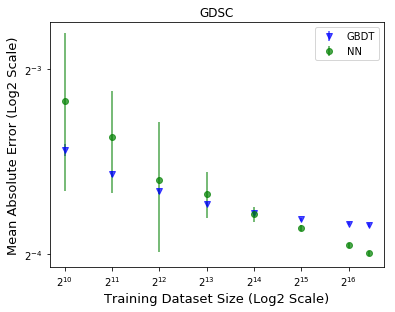

In [20]:
ax = None

# GBDT
x = lgb['tr_size'].values
y = lgb['median'].values
yerr = lgb['std'].values
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='GBDT')
# NN
x = nn['tr_size'].values
# y = nn['mean_absolute_error'].values
y = nn['median'].values
yerr = nn['std'].values
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='NN')
ax.set_title('GDSC')
ax.legend(frameon=True, fontsize=10, loc='best')
ax.grid(False)

GBDT GOF: {'rmse': 4.7580052786849905e-05, 'mae': 3.959250889588352e-05}
NN GOF: {'rmse': 0.0020116993692383253, 'mae': 0.0013886942620746114}
GBDT prms: {'alpha': 1.1706583311698957, 'beta': -0.556962177956806, 'gamma': 0.06761965078084099}
NN prms  : {'alpha': 0.5416823384200191, 'beta': -0.3236272868970528, 'gamma': 0.04936562833053135}


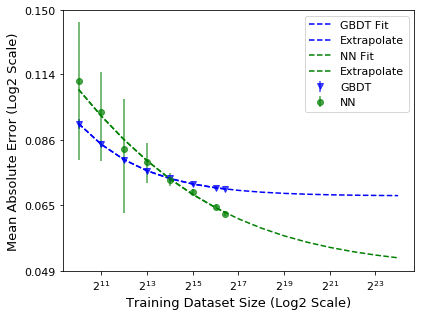

In [22]:
ax = None

# ----------------------------------------------------
# GBDT Data
x = lgb['tr_size'].values
y = lgb['median'].values
yerr = lgb['std'].values

# GBDT Fit
shard_min_id = 0
xf = x[shard_min_id:]
yf = y[shard_min_id:]
prms_lgb = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_lgb)

# Calc Fit beyond available size
xext_far = np.array([int(i) for i in 2 ** np.array(np.arange(25))[1:]])
idx_min = np.argmin( np.abs( xext_far - xf[0] ) )
xext_far = xext_far[idx_min:]
yext_far = biased_powerlaw(xext_far, **prms_lgb)

# GBDT GOF
gof = calc_gof(yf, yfit)
print('GBDT GOF:', gof)

# GBDT Data Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='GBDT')

# GBDT Fit Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='b', label='GBDT Fit')

# GBDT Extrapolate Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xext_far, y=yext_far,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='b', label='Extrapolate')

# ----------------------------------------------------
# NN Data
x = nn['tr_size'].values
y = nn['median'].values
# y = nn['mean_absolute_error']
yerr = nn['std'].values

# NN Fit
shard_min_id = 0
xf = x[shard_min_id:]
yf = y[shard_min_id:]
prms_nn = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_nn)

# Calc Fit beyond available size
xext_far = np.array([int(i) for i in 2 ** np.array(np.arange(25))[1:]])
idx_min = np.argmin( np.abs( xext_far - xf[0] ) )
xext_far = xext_far[idx_min:]
yext_far = biased_powerlaw(xext_far, **prms_nn)

# NN GOF
gof = calc_gof(yf, yfit)
print('NN GOF:', gof)

# NN Data Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='NN')

# NN Fit Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='g', label='NN Fit')

# GBDT Extrapolate Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xext_far, y=yext_far,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='g', label='Extrapolate')

# ----------------------------------------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(8, 18)])
# ax.set_xlim([xlim[0], 2**18]) 

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=11, loc='best');
ax.grid(False)
plt.tight_layout()
plt.savefig(save_fig_path/'gbdt_vs_nn_on_{}.png'.format(data_name), dpi=200)

print('GBDT prms:', prms_lgb)
print('NN prms  :', prms_nn)

# Top6 (GBDT vs NN)

In [22]:
data_name = 'top6'

In [23]:
lgb_shift_id = 0
# lgb_shift_id = 6
# lgb_shift_id = 7
lgb_shift_id = 8
lgb = lgb_top6[lgb_shift_id:].reset_index(drop=True)

nn_shift_id = lgb_shift_id - 6
nn = nn_top6[nn_shift_id:].reset_index(drop=True)

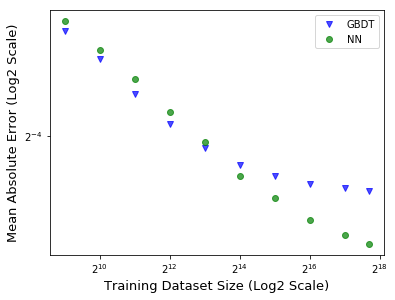

In [24]:
ax = None

# GBDT
x = lgb['tr_size'].values
y = lgb['median'].values
yerr = lgb['std'].values
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='GBDT')
# NN
x = nn['tr_size'].values
# y = nn['mean_absolute_error'].values
y = nn['median'].values
yerr = nn['std'].values
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='NN')
ax.set_title('Top6')
ax.legend(frameon=True, fontsize=10, loc='best')
ax.grid(False)

GOF: {'rmse': 0.0014508953070077497, 'mae': 0.0007929982774565122}
GOF: {'rmse': 0.0018272870324314613, 'mae': 0.00104047953529696}
{'alpha': 1.1378591588275215, 'beta': -0.540846090930934, 'gamma': 0.05142132269740189}
{'alpha': 0.4213949979592603, 'beta': -0.3197021458719373, 'gamma': 0.036592583367305594}


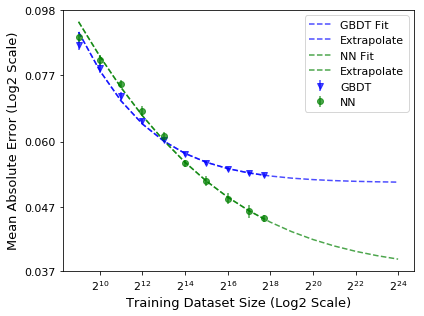

In [25]:
ax = None

# ----------------------------------------------------
# GBDT Data
x = lgb['tr_size'].values
y = lgb['median'].values
yerr = lgb['std'].values

# GBDT Fit
shard_min_id = 0
xf = x[shard_min_id:]
yf = y[shard_min_id:]
prms_lgb = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_lgb)

# Calc Fit beyond available size
xext_far = np.array([int(i) for i in 2 ** np.array(np.arange(25))[1:]])
idx_min = np.argmin( np.abs( xext_far - xf[0] ) )
xext_far = xext_far[idx_min:]
yext_far = biased_powerlaw(xext_far, **prms_lgb)

# GBDT GOF
gof = calc_gof(yf, yfit)
print('GOF:', gof)

# GBDT Data Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='GBDT')

# GBDT Fit Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=0.7,
                                   **plot_args, color='b', label='GBDT Fit')

# GBDT Extrapolate Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xext_far, y=yext_far,
                                   ax=ax, ls='--', marker='', alpha=0.7,
                                   **plot_args, color='b', label='Extrapolate')

# ----------------------------------------------------
# NN Data
x = nn['tr_size'].values
y = nn['median'].values
# y = nn['mean_absolute_error']
yerr = nn['std'].values

# NN Fit
shard_min_id = 0
xf = x[shard_min_id:]
yf = y[shard_min_id:]
prms_nn = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_nn)

# Calc Fit beyond available size
xext_far = np.array([int(i) for i in 2 ** np.array(np.arange(25))[1:]])
idx_min = np.argmin( np.abs( xext_far - xf[0] ) )
xext_far = xext_far[idx_min:]
yext_far = biased_powerlaw(xext_far, **prms_nn)

# NN GOF
gof = calc_gof(yf, yfit)
print('GOF:', gof)

# NN Data Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='NN')

# NN Fit Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=0.7,
                                   **plot_args, color='g', label='NN Fit')

# NN Extrapolate Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xext_far, y=yext_far,
                                   ax=ax, ls='--', marker='', alpha=0.7,
                                   **plot_args, color='g', label='Extrapolate')

# ----------------------------------------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(8, 18)])
# ax.set_xlim([xlim[0], 2**18]) 

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=11, loc='best');
ax.grid(False)
plt.tight_layout()
plt.savefig(save_fig_path/'gbdt_vs_nn_on_{}.png'.format(data_name), dpi=200)

print('GBDT prms:', prms_lgb)
print('NN prms  :', prms_nn)

# Same model (GBDT); different dataset

The LC plots show the same parameter beta for both datasets.

In [26]:
model_name = 'lgb'

In [27]:
lgb_shift_id = 0
lgb_shift_id = 9

lgb_gdsc_ = lgb_gdsc[lgb_shift_id:].reset_index(drop=True)

lgb_top6_ = lgb_top6[lgb_shift_id:].reset_index(drop=True)

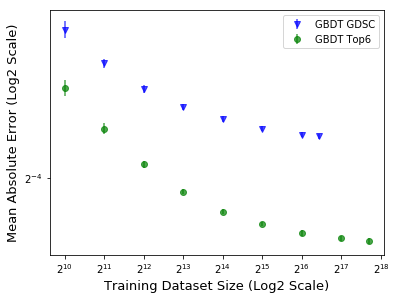

In [29]:
ax = None

# GDSC
x = lgb_gdsc_['tr_size'].values
y = lgb_gdsc_['median'].values
yerr = lgb_gdsc_['std'].values
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='GBDT GDSC')
# Top6
x = lgb_top6_['tr_size'].values
y = lgb_top6_['median'].values
yerr = lgb_top6_['std'].values
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='GBDT Top6')
ax.set_title('GBDT')
ax.legend(frameon=True, fontsize=10, loc='best')
ax.grid(False)

GBDT GDSC GOF: {'rmse': 4.7580052786849905e-05, 'mae': 3.959250889588352e-05}
GBDT Top6 GOF: {'rmse': 0.0004446066747408171, 'mae': 0.00027204718996853453}
{'alpha': 1.1706583311698957, 'beta': -0.556962177956806, 'gamma': 0.06761965078084099}
{'alpha': 1.6951677493590434, 'beta': -0.5888520332321653, 'gamma': 0.05171323899094677}


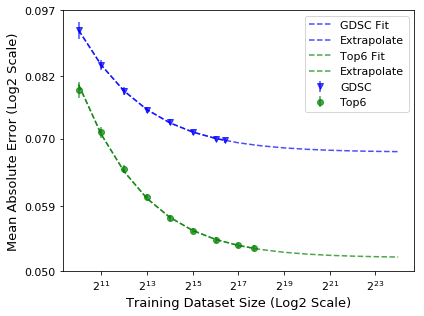

In [30]:
ax = None

# ----------------------------------------------------
# GDSC Data
x = lgb_gdsc_['tr_size'].values
y = lgb_gdsc_['median'].values
yerr = lgb_gdsc_['std'].values

# GDSC Fit
shard_min_id = 0
xf = x[shard_min_id:]
yf = y[shard_min_id:]
prms_lgb_gdsc = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_lgb_gdsc)

# Calc Fit beyond available size
xext_far = np.array([int(i) for i in 2 ** np.array(np.arange(25))[1:]])
idx_min = np.argmin( np.abs( xext_far - xf[0] ) )
xext_far = xext_far[idx_min:]
yext_far = biased_powerlaw(xext_far, **prms_lgb_gdsc)

# GDSC GOF
gof = calc_gof(yf, yfit)
print('GBDT GDSC GOF:', gof)

# GDSC Data Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='GDSC')

# GDSC Fit Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=0.7,
                                   **plot_args, color='b', label='GDSC Fit')

# GDSC Extrapolate Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xext_far, y=yext_far,
                                   ax=ax, ls='--', marker='', alpha=0.7,
                                   **plot_args, color='b', label='Extrapolate')

# ----------------------------------------------------
# Top6 Data
x = lgb_top6_['tr_size'].values
y = lgb_top6_['median'].values
# y = nn['mean_absolute_error']
yerr = lgb_top6_['std'].values

# Top6 Fit
shard_min_id = 0
xf = x[shard_min_id:]
yf = y[shard_min_id:]
prms_lgb_top6 = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_lgb_top6)

# Calc Fit beyond available size
xext_far = np.array([int(i) for i in 2 ** np.array(np.arange(25))[1:]])
idx_min = np.argmin( np.abs( xext_far - xf[0] ) )
xext_far = xext_far[idx_min:]
yext_far = biased_powerlaw(xext_far, **prms_lgb_top6)

# Top6 GOF
gof = calc_gof(yf, yfit)
print('GBDT Top6 GOF:', gof)

# Top6 Data Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='Top6')

# Top6 Fit Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=0.7,
                                   **plot_args, color='g', label='Top6 Fit')

# Top6 Extrapolate Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xext_far, y=yext_far,
                                   ax=ax, ls='--', marker='', alpha=0.7,
                                   **plot_args, color='g', label='Extrapolate')

# ----------------------------------------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(8, 18)])
# ax.set_xlim([xlim[0], 2**18]) 

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=11, loc='best');
ax.grid(False)
plt.tight_layout()
plt.savefig(save_fig_path/'gdsc_vs_top6_using_{}.png'.format(model_name), dpi=200)

print('GDSC', prms_lgb_gdsc)
print('Top6', prms_lgb_top6)

# Same model (NN); different dataset --> note! this is not the same model!

The LC plots show the same parameter beta for datasets.

In [34]:
model_name = 'nn'

In [35]:
# nn_shift_id = 0
nn_shift_id = 3

nn_gdsc_ = nn_gdsc[nn_shift_id:].reset_index(drop=True)

nn_top6_ = nn_top6[nn_shift_id:].reset_index(drop=True)

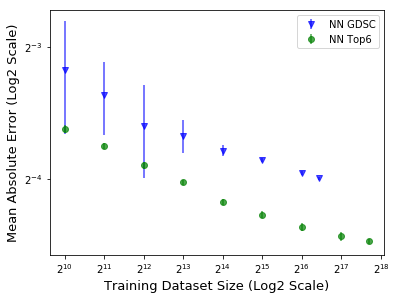

In [36]:
ax = None

x = nn_gdsc_['tr_size'].values
y = nn_gdsc_['median'].values
yerr = nn_gdsc_['std'].values
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='NN GDSC')
x = nn_top6_['tr_size'].values
y = nn_top6_['median'].values
yerr = nn_top6_['std'].values
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='NN Top6')

ax.legend(frameon=True, fontsize=10, loc='best')
ax.grid(False)

GBDT GDSC GOF: {'rmse': 0.0020116993692383253, 'mae': 0.0013886942620746114}
GBDT Top6 GOF: {'rmse': 0.0010605317580562998, 'mae': 0.0005777380772490286}
{'alpha': 0.5416823384200191, 'beta': -0.3236272868970528, 'gamma': 0.04936562833053135}
{'alpha': 0.5065706322318237, 'beta': -0.34390661400161615, 'gamma': 0.037511081914682096}


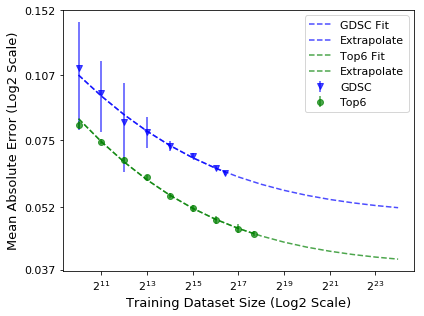

In [37]:
ax = None

# ----------------------------------------------------
# GDSC Data
x = nn_gdsc_['tr_size'].values
y = nn_gdsc_['median'].values
yerr = nn_gdsc_['std'].values

# GDSC Fit
shard_min_id = 0
xf = x[shard_min_id:]
yf = y[shard_min_id:]
prms_nn_gdsc = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_nn_gdsc)

# Calc Fit beyond available size
xext_far = np.array([int(i) for i in 2 ** np.array(np.arange(25))[1:]])
idx_min = np.argmin( np.abs( xext_far - xf[0] ) )
xext_far = xext_far[idx_min:]
yext_far = biased_powerlaw(xext_far, **prms_nn_gdsc)

# GDSC GOF
gof = calc_gof(yf, yfit)
print('GBDT GDSC GOF:', gof)

# GDSC Data Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=0.7,
                                   **plot_args, color='b', label='GDSC')

# GDSC Fit Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=0.7,
                                   **plot_args, color='b', label='GDSC Fit')

# GDSC Extrapolate Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xext_far, y=yext_far,
                                   ax=ax, ls='--', marker='', alpha=0.7,
                                   **plot_args, color='b', label='Extrapolate')

# ----------------------------------------------------
# Top6 Data
x = nn_top6_['tr_size'].values
y = nn_top6_['median'].values
# y = nn['mean_absolute_error']
yerr = nn_top6_['std'].values

# Top6 Fit
shard_min_id = 0
xf = x[shard_min_id:]
yf = y[shard_min_id:]
prms_nn_top6 = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms_nn_top6)

# Calc Fit beyond available size
xext_far = np.array([int(i) for i in 2 ** np.array(np.arange(25))[1:]])
idx_min = np.argmin( np.abs( xext_far - xf[0] ) )
xext_far = xext_far[idx_min:]
yext_far = biased_powerlaw(xext_far, **prms_nn_top6)

# Top6 GOF
gof = calc_gof(yf, yfit)
print('GBDT Top6 GOF:', gof)

# Top6 Data Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='o', alpha=0.7,
                                   **plot_args, color='g', label='Top6')

# Top6 Fit Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=0.7,
                                   **plot_args, color='g', label='Top6 Fit')

# Top6 Extrapolate Plot
ax = lrn_crv_plot.plot_lrn_crv_new(x=xext_far, y=yext_far,
                                   ax=ax, ls='--', marker='', alpha=0.7,
                                   **plot_args, color='g', label='Extrapolate')

# ----------------------------------------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(8, 18)])
# ax.set_xlim([xlim[0], 2**18]) 

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=11, loc='best');
ax.grid(False)
plt.tight_layout()
plt.savefig(save_fig_path/'gdsc_vs_top6_using_{}.png'.format(model_name), dpi=200)

print(prms_nn_gdsc)
print(prms_nn_top6)